# Import necessary libraries

In [2]:
from absl import flags
import sys
FLAGS = flags.FLAGS
sys.argv = sys.argv[:1]
FLAGS(sys.argv)

['C:\\Users\\Yassi\\anaconda3\\envs\\tf\\lib\\site-packages\\ipykernel_launcher.py']

In [3]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import convert_boxes

In [8]:
from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet

In [5]:
class_names = [c.strip() for c in open('./data/labels/coco.names').readlines()]
yolo = YoloV3(classes=len(class_names))
yolo.load_weights('./weights/yolov3.tf')

In [6]:
max_cosine_distance = 0.5
nn_budget = None
nms_max_overlap = 0.8

In [ ]:
model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric('cosine', max_cosine_distance, nn_budget)
tracker = Tracker(metric)

In [8]:
vid = cv2.VideoCapture('./data/video/project_video.mp4')

In [ ]:
codec = cv2.VideoWriter_fourcc(*'XVID')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results.avi', codec, vid_fps, (vid_width, vid_height))

In [1]:
from _collections import deque
pts = [deque(maxlen=30) for _ in range(1000)]

In [17]:
counter = []
k=0
allcenters = []
centers = []
centers_x = []
centers_y = []

# Tracking algorithm

In [ ]:
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break

    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0)
    img_in = transform_images(img_in, 416)

    t1 = time.time()

    boxes, scores, classes, nums = yolo.predict(img_in)

    classes = classes[0]
    names = []
    for i in range(len(classes)):
        names.append(class_names[int(classes[i])])
    names = np.array(names)
    converted_boxes = convert_boxes(img, boxes[0])
    features = encoder(img, converted_boxes)

    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                  zip(converted_boxes, scores[0], names, features)]

    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    tracker.predict()
    tracker.update(detections)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

    current_count = int(0)
    #centers = []
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        bbox = track.to_tlbr()
        class_name= track.get_class()
        color = colors[int(track.track_id) % len(colors)]
        color = [i * 255 for i in color]

        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                    +len(str(track.track_id)))*17, int(bbox[1])), color, -1)
        cv2.putText(img, class_name+"-"+str(track.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255, 255, 255), 2)

        k=k+1
        x = int(((bbox[0]) + (bbox[2]))/2)
        y = int(((bbox[1])+(bbox[3]))/2)
        x = float(x)
        y = float(y)
        center = [x, y]
        #center = np.array(center)
        #pts[track.track_id].append(center)
        centers.append([center, k, track.track_id])
        centers_x.append([x, k, track.track_id])
        centers_y.append([y, k, track.track_id])
        
        #print(centers)
        

        for j in range(1, len(pts[track.track_id])):
            if pts[track.track_id][j-1] is None or pts[track.track_id][j] is None:
                continue
            thickness = int(np.sqrt(64/float(j+1))*2)
            cv2.line(img, (pts[track.track_id][j-1]), (pts[track.track_id][j]), color, thickness)

        height, width, _ = img.shape
        cv2.line(img, (0, int(3*height/6+height/20)), (width, int(3*height/6+height/20)), (0, 255, 0), thickness=2)
        cv2.line(img, (0, int(3*height/6-height/20)), (width, int(3*height/6-height/20)), (0, 255, 0), thickness=2)

        center_y = int(((bbox[1])+(bbox[3]))/2)

        if center_y <= int(3*height/6+height/20) and center_y >= int(3*height/6-height/20):
            if class_name == 'car' or class_name == 'truck':
                counter.append(int(track.track_id))
                current_count += 1
    #allcenters.append(centers)

    total_count = len(set(counter))
    cv2.putText(img, "Current Vehicle Count: " + str(current_count), (0, 80), 0, 1, (0, 0, 255), 2)
    cv2.putText(img, "Total Vehicle Count: " + str(total_count), (0,130), 0, 1, (0,0,255), 2)

    fps = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'):
        break
vid.release()
out.release()
cv2.destroyAllWindows()

In [12]:
import pandas as pd

# Extract abscissa and ordinate independently

In [15]:
df_x = pd.DataFrame(centers_x, columns=["x", "temps", "index"])
df_y = pd.DataFrame(centers_y, columns=["y", "temps", "index"])

In [16]:
df_x

,x,temps,index
0,276.0,1,6
1,267.0,2,6
2,260.0,3,6
3,252.0,4,6
4,244.0,5,6
...,...,...,...
2745,807.0,2746,128
2746,1219.0,2747,136
2747,669.0,2748,252
2748,807.0,2749,128


In [17]:
df_y

,y,temps,index
0,427.0,1,6
1,426.0,2,6
2,426.0,3,6
3,426.0,4,6
4,427.0,5,6
...,...,...,...
2745,441.0,2746,128
2746,435.0,2747,136
2747,406.0,2748,252
2748,443.0,2749,128


In [13]:
dic_x=dict()
dicc_x=dict()
dic_y=dict()
dicc_y=dict()

# Assign data to each object

In [19]:
for x in df_x['index'].unique():
    dic_x[x]= df_x[df_x['index']==x]
    dic_x[x] = dic_x[x].drop(columns=['temps'])
    dic_x[x] = dic_x[x].drop(columns=['index'])
    dicc_x[x] = dic_x[x]
    dic_x[x] = dic_x[x].values.tolist()

In [20]:
for y in df_y['index'].unique():
    dic_y[y]= df_y[df_y['index']==y]
    dic_y[y] = dic_y[y].drop(columns=['temps'])
    dic_y[y] = dic_y[y].drop(columns=['index'])
    dicc_y[y] = dic_y[y]
    dic_y[y] = dic_y[y].values.tolist()

In [14]:
dic2_x = dict()
dic2_y = dict()

# Data structuring

In [22]:
for key in dicc_x:    
    n=0
    dic2_x[key]=list()
    for lin in dicc_x[key].index:
        if n+4 > len(dicc_x[key])-1:
            #print(str(key)+"      "+str(n)+"    "+str(len(dic[key])-5)+"    "+str(len(dic[key])-1))
            break
        x1 = dic_x[key][n][0]
        x2 = dic_x[key][n+1][0]
        x3 = dic_x[key][n+2][0]
        x4 = dic_x[key][n+3][0]
        x5 = dic_x[key][n+4][0]
        n = n+5
        #print(n)
        #print(lin+4)
        dic2_x[key].append([x1, x2, x3, x4, x5])
    dic2_x[key] = pd.DataFrame(dic2_x[key], columns=["x1", "x2", "x3", "x4", "x5"])
    #break

In [23]:
for key in dicc_y:    
    n=0
    dic2_y[key]=list()
    for lin in dicc_y[key].index:
        if n+4 > len(dicc_y[key])-1:
            #print(str(key)+"      "+str(n)+"    "+str(len(dic[key])-5)+"    "+str(len(dic[key])-1))
            break
        y1 = dic_y[key][n][0]
        y2 = dic_y[key][n+1][0]
        y3 = dic_y[key][n+2][0]
        y4 = dic_y[key][n+3][0]
        y5 = dic_y[key][n+4][0]
        n = n+5
        #print(n)
        #print(lin+4)
        dic2_y[key].append([y1, y2, y3, y4, y5])
    dic2_y[key] = pd.DataFrame(dic2_y[key], columns=["y1", "y2", "y3", "y4", "y5"])
    #break

In [25]:
X_feature = []
X_target = []
Y_feature = []
Y_target = []

# Differentiate between features and targets

In [26]:
for key in dic2_x:
    feature_x = dic2_x[key][["x1", "x2", "x3", "x4"]]
    target_x = dic2_x[key][["x5"]]
    for i in range(len(feature_x)):
        X_feature.append(np.array([feature_x.iloc[i][0], feature_x.iloc[i][1], feature_x.iloc[i][2], feature_x.iloc[i][3]]).ravel())
        X_target.append(np.array([target_x.iloc[i][0]]))

In [27]:
for key in dic2_y:
    feature_y = dic2_y[key][["y1", "y2", "y3", "y4"]]
    target_y = dic2_y[key][["y5"]]
    for i in range(len(feature_y)):
        Y_feature.append(np.array([feature_y.iloc[i][0], feature_y.iloc[i][1], feature_y.iloc[i][2], feature_y.iloc[i][3]]).ravel())
        Y_target.append(np.array([target_y.iloc[i][0]]))

In [28]:
target_y.iloc[0][0]

406.0

# Transforming our data into numpy arrays

In [ ]:
X_feature = np.array(X_feature)
Y_feature = np.array(Y_feature)

In [32]:
X_feature

array([[276., 267., 260., 252.],
       [236., 226., 217., 207.],
       [185., 172., 158., 143.],
       ...,
       [729., 728., 728., 726.],
       [677., 677., 677., 673.],
       [671., 672., 671., 670.]])

In [33]:
X_target=np.array(X_target)
Y_target=np.array(Y_target)

# Split data

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
Xfeature_train, Xfeature_test, xtarget_train, xtarget_test = train_test_split(X_feature , X_target, test_size=0.3, random_state=0)

In [37]:
Yfeature_train, Yfeature_test, ytarget_train, ytarget_test = train_test_split(Y_feature , Y_target, test_size=0.3, random_state=0)

# Linear regression model

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
model_reglin_X = LinearRegression()

In [40]:
model_reglin_Y = LinearRegression()

In [41]:
model_reglin_Y.fit(Yfeature_train, ytarget_train)

LinearRegression()

In [42]:
print('test score = %0.2f, train score = %0.2f' %(model_reglin_Y.score(Yfeature_test, ytarget_test), model_reglin_Y.score(Yfeature_train, ytarget_train)))

test score = 0.99, train score = 1.00


In [43]:
y_pred_lin = model_reglin_Y.predict(Yfeature_test)

Text(0, 0.5, 'y_test')

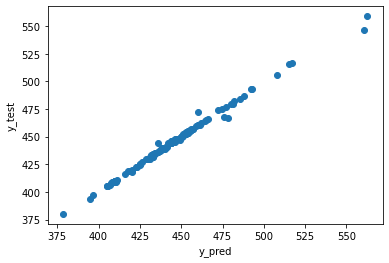

In [47]:
plt.scatter(y_pred_lin, ytarget_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')

In [49]:
model_reglin_X.fit(Xfeature_train, xtarget_train)

LinearRegression()

In [50]:
print('test score = %0.2f, train score = %0.2f' %(model_reglin_X.score(Xfeature_test,xtarget_test), model_reglin_X.score(Xfeature_train,xtarget_train)))

test score = 1.00, train score = 1.00


In [51]:
x_pred_lin = model_reglin_X.predict(Xfeature_test)

In [134]:
l = [[x1, x2, x3, x4]]

In [135]:
l

[[671.0, 672.0, 671.0, 670.0]]

In [136]:
type(l)

list

In [137]:
l = np.array(l)

In [138]:
l

array([[671., 672., 671., 670.]])

In [139]:
l.shape

(1, 4)

In [133]:
l = l.reshape(4,)

In [124]:
l

array([[671.],
       [672.],
       [671.],
       [670.]])

In [140]:
f = reglin_X.predict(l)

In [141]:
f

array([[668.67334942]])

Text(0, 0.5, 'x_test')

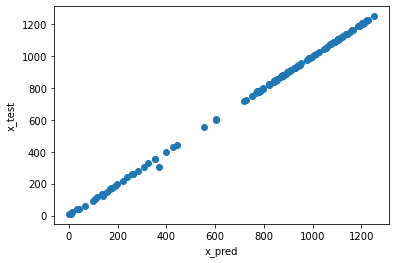

In [52]:
plt.scatter(x_pred_lin, xtarget_test)
plt.xlabel('x_pred')
plt.ylabel('x_test')

# Saving the linear regression model

In [13]:
import pickle

In [80]:
filename_x = 'reglin_x.sav'
pickle.dump(model_reglin_X, open(filename_x, 'wb'))

In [81]:
filename_y = 'reglin_y.sav'
pickle.dump(model_reglin_Y, open(filename_y, 'wb'))

In [14]:
with open('reglin_x.sav', 'rb') as file:  
    reglin_X = pickle.load(file)

In [15]:
with open('reglin_y.sav', 'rb') as file:  
    reglin_Y = pickle.load(file)

# Support Vector Regressor model

In [53]:
from sklearn.svm import SVR

In [54]:
lin_svr_X = SVR(kernel='linear', C=1)

In [55]:
lin_svr_X.fit(Xfeature_train, xtarget_train)

C:\Users\Yassi\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(C=1, kernel='linear')

In [56]:
print('test score = %0.2f, train score = %0.2f' %(lin_svr_X.score(Xfeature_test,xtarget_test), lin_svr_X.score(Xfeature_train,xtarget_train)))

test score = 1.00, train score = 1.00


In [57]:
x_pred_svr = lin_svr_X.predict(Xfeature_test)

Text(0, 0.5, 'x_test')

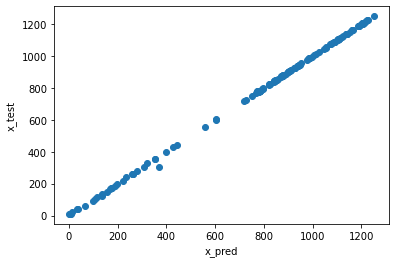

In [58]:
plt.scatter(x_pred_svr, xtarget_test)
plt.xlabel('x_pred')
plt.ylabel('x_test')

In [59]:
lin_svr_Y = SVR(kernel='linear', C=1)

In [60]:
lin_svr_Y.fit(Yfeature_train, ytarget_train)

C:\Users\Yassi\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVR(C=1, kernel='linear')

In [61]:
print('test score = %0.2f, train score = %0.2f' %(lin_svr_Y.score(Yfeature_test,ytarget_test), lin_svr_Y.score(Yfeature_train,ytarget_train)))

test score = 0.99, train score = 1.00


In [71]:
Y_pred_svr = lin_svr_Y.predict(Yfeature_test)

Text(0, 0.5, 'Y_test')

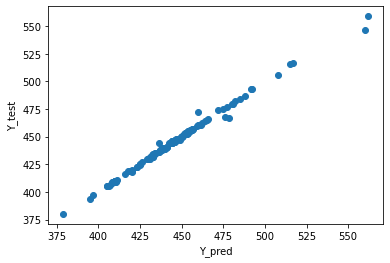

In [72]:
plt.scatter(Y_pred_svr, ytarget_test)
plt.xlabel('Y_pred')
plt.ylabel('Y_test')

# MLP Regressor

In [64]:
from sklearn.neural_network import MLPRegressor

In [65]:
regr_X = MLPRegressor(hidden_layer_sizes=[10,10,10], random_state=1, solver='lbfgs',max_iter=500)

In [66]:
regr_X.fit(Xfeature_train, xtarget_train)

C:\Users\Yassi\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Yassi\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(hidden_layer_sizes=[10, 10, 10], max_iter=500, random_state=1,
             solver='lbfgs')

In [67]:
print('test score = %0.2f, train score = %0.2f' %(regr_X.score(Xfeature_test,xtarget_test), regr_X.score(Xfeature_train,xtarget_train)))

test score = 1.00, train score = 1.00


In [73]:
X_pred_MLP = regr_X.predict(Xfeature_test)

Text(0, 0.5, 'x_test')

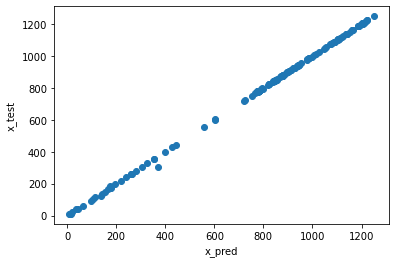

In [74]:
plt.scatter(X_pred_MLP, xtarget_test)
plt.xlabel('x_pred')
plt.ylabel('x_test')

In [68]:
regr_Y = MLPRegressor(hidden_layer_sizes=[10,10,10], random_state=1, solver='lbfgs',max_iter=500)

In [69]:
regr_Y.fit(Yfeature_train, ytarget_train) 

C:\Users\Yassi\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MLPRegressor(hidden_layer_sizes=[10, 10, 10], max_iter=500, random_state=1,
             solver='lbfgs')

In [70]:
print('test score = %0.2f, train score = %0.2f' %(regr_Y.score(Yfeature_test,ytarget_test), regr_Y.score(Yfeature_train,ytarget_train)))

test score = 0.99, train score = 1.00


In [75]:
Y_pred_MLP = regr_Y.predict(Yfeature_test)

Text(0, 0.5, 'y_test')

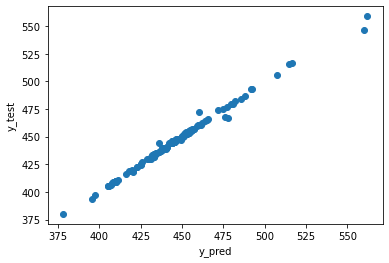

In [76]:
plt.scatter(Y_pred_MLP, ytarget_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')

# Real-time prediction

In [16]:
counter = []
k=0
idd = []
allcenters = []
centers = []
centers_x = []
centers_y = []
feature_x = []
target_x = []
feature_y = []
target_y = []
dic_x = dict()
dic_y = dict()
dic2_x=dict()
dic2_y=dict()
dicc_x=dict()
dicc_y=dict()
n=0
couleur = (0,255,0)

In [18]:
vid = cv2.VideoCapture('./data/video/project_video.mp4')

In [ ]:
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break

    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0)
    img_in = transform_images(img_in, 416)

    t1 = time.time()

    boxes, scores, classes, nums = yolo.predict(img_in)

    classes = classes[0]
    names = []
    for i in range(len(classes)):
        names.append(class_names[int(classes[i])])
    names = np.array(names)
    converted_boxes = convert_boxes(img, boxes[0])
    features = encoder(img, converted_boxes)

    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                  zip(converted_boxes, scores[0], names, features)]

    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    tracker.predict()
    tracker.update(detections)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

    current_count = int(0)
    #centers = []
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        bbox = track.to_tlbr()
        class_name= track.get_class()
        color = colors[int(track.track_id) % len(colors)]
        color = [i * 255 for i in color]

        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                    +len(str(track.track_id)))*17, int(bbox[1])), color, -1)
        cv2.putText(img, class_name+"-"+str(track.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255, 255, 255), 2)

        k=k+1
        x = int(((bbox[0]) + (bbox[2]))/2)
        y = int(((bbox[1])+(bbox[3]))/2)
        x = float(x)
        y = float(y)
        center = [x, y]
        #center = np.array(center)
        #pts[track.track_id].append(center)
        centers.append([center, k, track.track_id])
        centers_x.append([x, k, track.track_id])
        centers_y.append([y, k, track.track_id])
        idd.append(track.track_id)
        if k == 1:
            dff_x = pd.DataFrame(centers_x, columns=["x", "temps", "index"])
            dff_y = pd.DataFrame(centers_y, columns=["y", "temps", "index"])
            dff_x = dff_x.drop(columns=['temps'])
            dff_y = dff_y.drop(columns=['temps'])
            
        else:
            dfff_x = pd.DataFrame(centers_x, columns=["x", "temps", "index"])
            dfff_y = pd.DataFrame(centers_y, columns=["y", "temps", "index"])
            dfff_x = dfff_x.drop(columns=['temps'])
            dfff_y = dfff_y.drop(columns=['temps'])
            dff_x = pd.concat([dff_x, dfff_x], axis=0)
            dff_y = pd.concat([dff_y, dfff_y], axis=0)
        for x in dff_x['index'].unique():
            dic_x[x]= dff_x[dff_x['index']==x]
            dicc_x[x] = dic_x[x]
            dic_x[x] = dic_x[x].values.tolist()
        for y in dff_y['index'].unique():
            dic_y[y]= dff_y[dff_y['index']==y]
            dicc_y[y] = dic_y[y]
            dic_y[y] = dic_y[y].values.tolist()
        for key in dicc_x:
            n=0
            for j in range(len(dicc_x[key])):
                n=n+1
                if n < len(dicc_x[key])-1:
                    if n>=3:
                        dic2_x[key]=list()
                        x1 = dic_x[key][n-3][0]
                        x2 = dic_x[key][n-2][0]
                        x3 = dic_x[key][n-1][0]
                        x4 = dic_x[key][n][0]
                        x1 = int(x1)
                        x2 = int(x2)
                        x3 = int(x3)
                        x4 = int(x4)
                        l_x = [[x1, x2, x3, x4]]
                        l_x = np.array(l_x)
                        x_pred = reglin_X.predict(l_x)
                        x_pred = int(x_pred)
                        y1 = dic_y[key][n-3][0]
                        y2 = dic_y[key][n-2][0]
                        y3 = dic_y[key][n-1][0]
                        y4 = dic_y[key][n][0]
                        y1 = int(y1)
                        y2 = int(y2)
                        y3 = int(y3)
                        y4 = int(y4)
                        l_y = [[y1, y2, y3, y4]]
                        l_y = np.array(l_y)
                        y_pred = reglin_Y.predict(l_y)
                        y_pred = int(y_pred)
                        cv2.line(img, (x4, y4), (x_pred, y_pred) , (0, 255, 0) , thickness=2)
                    
                #cv2.line(img, x4, x_pred, color, thickness)
        #for key in dicc_y:
         #   n=0
          #  for j in range(len(dicc_y[key])):
           #     n=n+1
            #    if n < len(dicc_x[key])-1:
             #       if n>=3:
              #          dic2_y[key]=list()
               #         y1 = dic_y[key][n-3][0]
               #         y2 = dic_y[key][n-2][0]
                #        y3 = dic_y[key][n-1][0]
                 #       y4 = dic_y[key][n][0]
                  #      y1 = int(y1)
       #                 y2 = int(y2)
        #                y3 = int(y3)
         #               y4 = int(y4)
          #              l_y = [[y1, y2, y3, y4]]
           #             l_y = np.array(l_y)
            #            y_pred = reglin_Y.predict(l_y)
             #           y_pred = int(y_pred)
              #          cv2.line(img, (x4, y4), (x_pred, y_pred) , (0, 255, 0) , thickness=2)
        
        #print(centers)
        

        for j in range(1, len(pts[track.track_id])):
            if pts[track.track_id][j-1] is None or pts[track.track_id][j] is None:
                continue
            thickness = int(np.sqrt(64/float(j+1))*2)
            cv2.line(img, (pts[track.track_id][j-1]), (pts[track.track_id][j]), color, thickness)

        height, width, _ = img.shape
        cv2.line(img, (0, int(3*height/6+height/20)), (width, int(3*height/6+height/20)), (0, 255, 0), thickness=2)
        cv2.line(img, (0, int(3*height/6-height/20)), (width, int(3*height/6-height/20)), (0, 255, 0), thickness=2)

        center_y = int(((bbox[1])+(bbox[3]))/2)

        if center_y <= int(3*height/6+height/20) and center_y >= int(3*height/6-height/20):
            if class_name == 'car' or class_name == 'truck':
                counter.append(int(track.track_id))
                current_count += 1
    #allcenters.append(centers)

    total_count = len(set(counter))
    cv2.putText(img, "Current Vehicle Count: " + str(current_count), (0, 80), 0, 1, (0, 0, 255), 2)
    cv2.putText(img, "Total Vehicle Count: " + str(total_count), (0,130), 0, 1, (0,0,255), 2)

    fps = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    out.write(img)

    if cv2.waitKey(1) == ord('q'):
        break
vid.release()
out.release()
cv2.destroyAllWindows()

In [37]:
dicc_x[6]

,x,index,y
0,276.0,6,NaN
0,NaN,6,427.0
1,NaN,6,427.0
0,NaN,6,427.0
1,NaN,6,427.0
0,NaN,6,427.0
1,NaN,6,427.0


In [56]:
dff_x

,x,index,x,index
0,273.0,42.0,273.0,42
1,NaN,NaN,276.0,48


In [43]:
idd

[24, 30, 30, 30]

# Webcam connection

In [13]:
url = 'http://192.168.43.1:8080/shot.jpg'
font = cv2.FONT_HERSHEY_SIMPLEX

In [15]:
import requests
from PIL import Image
from io import BytesIO

In [ ]:
while True:
    r = requests.get(url)
    image =Image.open(BytesIO(r.content))
    image=image.resize((224,224),Image.ANTIALIAS)
    np_im = np.array(image)
    img_arr = np.array(bytearray(r.content), dtype=np.uint8)
    img = cv2.imdecode(img_arr, -1)
    np_im=np_im.reshape((1,)+np_im.shape)

    

    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0)
    img_in = transform_images(img_in, 416)

    t1 = time.time()

    boxes, scores, classes, nums = yolo.predict(img_in)

    classes = classes[0]
    names = []
    for i in range(len(classes)):
        names.append(class_names[int(classes[i])])
    names = np.array(names)
    converted_boxes = convert_boxes(img, boxes[0])
    features = encoder(img, converted_boxes)

    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                  zip(converted_boxes, scores[0], names, features)]

    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]

    tracker.predict()
    tracker.update(detections)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

    current_count = int(0)
    #centers = []
    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        bbox = track.to_tlbr()
        class_name= track.get_class()
        color = colors[int(track.track_id) % len(colors)]
        color = [i * 255 for i in color]

        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), color, 2)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                    +len(str(track.track_id)))*17, int(bbox[1])), color, -1)
        cv2.putText(img, class_name+"-"+str(track.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255, 255, 255), 2)

        k=k+1
        x = int(((bbox[0]) + (bbox[2]))/2)
        y = int(((bbox[1])+(bbox[3]))/2)
        x = float(x)
        y = float(y)
        center = [x, y]
        #center = np.array(center)
        #pts[track.track_id].append(center)
        centers.append([center, k, track.track_id])
        centers_x.append([x, k, track.track_id])
        centers_y.append([y, k, track.track_id])
        
        #print(centers)
        

        for j in range(1, len(pts[track.track_id])):
            if pts[track.track_id][j-1] is None or pts[track.track_id][j] is None:
                continue
            thickness = int(np.sqrt(64/float(j+1))*2)
            cv2.line(img, (pts[track.track_id][j-1]), (pts[track.track_id][j]), color, thickness)

        height, width, _ = img.shape
        cv2.line(img, (0, int(3*height/6+height/20)), (width, int(3*height/6+height/20)), (0, 255, 0), thickness=2)
        cv2.line(img, (0, int(3*height/6-height/20)), (width, int(3*height/6-height/20)), (0, 255, 0), thickness=2)

        center_y = int(((bbox[1])+(bbox[3]))/2)

        if center_y <= int(3*height/6+height/20) and center_y >= int(3*height/6-height/20):
            if class_name == 'car' or class_name == 'truck':
                counter.append(int(track.track_id))
                current_count += 1
    #allcenters.append(centers)

    total_count = len(set(counter))
    cv2.putText(img, "Current Vehicle Count: " + str(current_count), (0, 80), 0, 1, (0, 0, 255), 2)
    cv2.putText(img, "Total Vehicle Count: " + str(total_count), (0,130), 0, 1, (0,0,255), 2)

    fps = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    cv2.resizeWindow('output', 1024, 768)
    cv2.imshow('output', img)
    #out.write(img)

    if cv2.waitKey(1) == ord('q'):
        break
vid.release()
out.release()
cv2.destroyAllWindows()